In [180]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from scipy.stats import randint

from xgboost import XGBClassifier

In [48]:
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")

In [39]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [38]:
train.shape

(891, 12)

In [128]:
data = train.drop(columns=["Name"])

In [129]:
data["HasCabin"] = data["Cabin"].isnull().apply(lambda x: 0 if x else 1)

In [130]:
sex = {"male" : 0, "female":1}
data["Sex"] = data["Sex"].replace(sex)

In [131]:
data = data.drop(columns=["Ticket", "Cabin"])

In [132]:
data[data["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,HasCabin
61,62,1,1,1,38.0,0,0,80.0,NaN,1
829,830,1,1,1,62.0,0,0,80.0,NaN,1


In [133]:
mean_age_by_class_sex = data.groupby(["Pclass", "Sex"])["Age"].mean().reset_index()

In [134]:
mean_age_by_class_sex[(mean_age_by_class_sex["Pclass"] == 3) & (mean_age_by_class_sex["Sex"] == 0)]["Age"].iloc[0]

26.507588932806325

In [135]:
def ageImputer(row):
    row["Age"] =  mean_age_by_class_sex[(mean_age_by_class_sex["Pclass"] == row["Pclass"]) & (mean_age_by_class_sex["Sex"] == row["Sex"])]["Age"].iloc[0]
    return row

In [136]:
data.loc[data["Age"].isnull(), "Age"] = data.loc[data["Age"].isnull(), ].apply(ageImputer, axis=1)["Age"]

In [137]:
data.groupby(["Pclass", "HasCabin"]).size()

Pclass  HasCabin
1       0            40
        1           176
2       0           168
        1            16
3       0           479
        1            12
dtype: int64

In [138]:
data = data.dropna()

In [139]:
fare_mean = data.groupby(["Pclass", "Embarked", "Sex"])["Fare"].mean().reset_index()

In [140]:
def fareImputer(row):
    row["Fare"] =  fare_mean[(fare_mean["Pclass"] == row["Pclass"]) & (fare_mean["Sex"] == row["Sex"]) & (fare_mean["Embarked"] == row["Embarked"])]["Fare"].iloc[0]
    return row

In [141]:
data.loc[data["Fare"].isnull(), "Fare"] = data.loc[data["Fare"].isnull(), ].apply(ageImputer, axis=1)["Fare"]

In [142]:
data = pd.get_dummies(data)

In [163]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["PassengerId", "Survived"]), data["Survived"], test_size=0.3, random_state=42)

In [176]:
xgbmodel = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=3)
xgbmodel.fit(X_train, y_train)
xgbmodel.score(X_test, y_test)

0.8164794007490637

In [186]:
param_dist = {"max_depth": [3],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

In [182]:
model = XGBClassifier()

In [187]:
random_search = RandomizedSearchCV(model, param_dist)
random_search.fit(X_train, y_train)

C:\Users\eakhumb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_al...
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3],
                                   

In [189]:
random_search.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 1,
 'min_samples_leaf': 5}

In [191]:
test_data = test.drop(columns=["Name"])
test_data["HasCabin"] = test_data["Cabin"].isnull().apply(lambda x: 0 if x else 1)
test_data["Sex"] = test_data["Sex"].replace(sex)
test_data = test_data.drop(columns=["Ticket", "Cabin"])
test_data.loc[test_data["Age"].isnull(), "Age"] = test_data.loc[test_data["Age"].isnull(), ].apply(ageImputer, axis=1)["Age"]
test_data.loc[test_data["Fare"].isnull(), "Fare"] = test_data.loc[test_data["Fare"].isnull(), ].apply(ageImputer, axis=1)["Fare"]
test_data = pd.get_dummies(test_data)

In [193]:
submission = test_data[["PassengerId"]]

In [194]:
submission["Survived"] = xgbmodel.predict(test_data.drop(columns=["PassengerId"]))

C:\Users\eakhumb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [196]:
submission.shape, test.shape

((418, 2), (418, 11))

In [198]:
submission.to_csv("Data\Submission.csv", index=False)

In [200]:
leader_board = pd.read_csv("Data/titanic-publicleaderboard.csv")

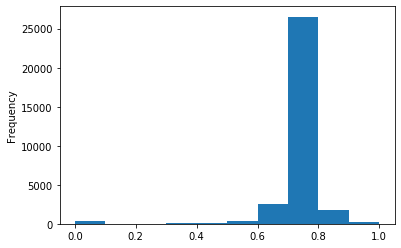

In [205]:
leader_board["Score"].plot(kind="hist")

In [209]:
leader_board[leader_board["Score"]==1].shape[0], leader_board.shape[0]

(98, 32082)